In [1]:
import numpy as np
import networkx as nx
import pprint as pp
import torch
import torch.nn as nn
import torch.nn.functional as F
import  gymnasium as gym
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
# create a grid graph
WIDTH = 4
HEIGHT = 4

In [3]:

# build the sum of the adjency matrix and the identity matrix, with power
def build_transition_matrix(adj, power):
    adj = adj + np.identity(adj.shape[0])
    for i in range(power-1):
        adj = np.matmul(adj, adj)
    return adj

In [4]:
def initialize_state(thief_position : tuple, cop_position : tuple, graph: nx.Graph):
    for node in graph.nodes():
        graph.nodes[node]["agent"] = 0

    graph.nodes[thief_position]["agent"] = 1
    graph.nodes[cop_position]["agent"] = 2

    return graph
def plot_graph(graph):
    # plot thief in red, cop in blue
    node_colors = []
    for node in graph.nodes():
        if graph.nodes[node]["agent"] == 1:
            node_colors.append("red")
        elif graph.nodes[node]["agent"] == 2:
            node_colors.append("blue")
        else:
            node_colors.append("green")
    pos = {(i, j): (i, -j) for i, j in graph.nodes()}  # Specify positions for nodes
    plt.figure(figsize=(5, 5))  # Set the size of the plot
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color=node_colors, font_size=10, font_weight='bold')
    plt.title('Grid Graph', fontsize=12)
    plt.show()


In [5]:
def adjency_matrix_to_mask(adj):
    mask = np.zeros(adj.shape)
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] > 0:
                mask[i, j] = 0
            else:
                mask[i, j] = -np.inf
    return mask

In [6]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self,embedding_dim,head_num,masked=False,device="cpu"):
        super(MultiHeadAttention,self).__init__()
        self.embedding_dim = embedding_dim
        self.head_num = head_num

        self.device=device

        print(f"device {self.device}")
        self.masked = False

        #assert embedding_dim % head_num == 0 , "embedding_dim must be divisible by head_num"
        assert head_num > 0 , "head_num must be greater than 0"

        self.head_dim = self.embedding_dim // head_num

        self.fc_Q = nn.Linear(self.embedding_dim,self.embedding_dim)
        self.fc_K = nn.Linear(self.embedding_dim,self.embedding_dim)
        self.fc_V = nn.Linear(self.embedding_dim,self.embedding_dim)
        self.uni_head = nn.Linear(self.head_num * self.head_dim,self.embedding_dim)


    def forward(self,x,mask_matrix):
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        Q = self.fc_Q(x)
        K = self.fc_K(x)
        V = self.fc_V(x)

        # split heads
        Q = Q.view(batch_size,seq_len,self.head_num,self.head_dim)
        K = K.view(batch_size,seq_len,self.head_num,self.head_dim)
        V = V.view(batch_size,seq_len,self.head_num,self.head_dim)

        Q  = Q.view(batch_size * self.head_num,seq_len,self.head_dim)
        K  = K.view(batch_size * self.head_num,seq_len,self.head_dim)
        V  = V.view(batch_size * self.head_num,seq_len,self.head_dim)


        # attention

        dot_product = torch.bmm(Q,K.transpose(1,2))
        mask_matrix = torch.tensor(mask_matrix,dtype=torch.float32,device=self.device)
        #duplicate mask for each head

        mask_matrix = mask_matrix.repeat(self.head_num*batch_size,1,1)

        dot_product = dot_product + mask_matrix
        dot_product = dot_product / np.sqrt(self.head_dim)
        dot_product = F.softmax(dot_product,dim=2)
        attention = torch.bmm(dot_product,V)
        if self.masked:
            # get a 0 under the diagonal, and -inf everywhere else
            mask = torch.triu(torch.full((seq_len,seq_len), float('-inf')), diagonal=1)
            # apply mask to scores
            attention += mask

        attention  = attention.view(batch_size , self.head_num,seq_len,self.head_dim)
        attention = attention.view(batch_size,seq_len,self.head_num * self.head_dim)
        # concat heads

        return self.uni_head(attention)

In [7]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,embedding_dim,head_num,device="cpu"):
        super(TransformerEncoderBlock,self).__init__()
        print(f"device 2 {device}")
        self.multi_head_attention = MultiHeadAttention(embedding_dim,head_num,device=device)
        self.multi_head_attention.to(device)
        self.fc = nn.Linear(embedding_dim,1)
        self.fc.to(device)

        self.norm = nn.LayerNorm(embedding_dim)
        self.norm.to(device)

    def forward(self,x,mask_matrix):

        attention = self.multi_head_attention(x,mask_matrix)
        x = attention + x
        #x = self.norm(x)
        fully_connected = self.fc(x)

        x = fully_connected + x
        #x = self.norm(x)
        return x

In [8]:
class q_network_graph_attention(nn.Module):
    def __init__(self,embedding_dim,head_num,node_graph_dim,action_dim,device="cpu"):
        super(q_network_graph_attention,self).__init__()
        self.embedding_dim = embedding_dim

        self.head_num = head_num
        self.transformer_encoder = TransformerEncoderBlock(embedding_dim,head_num,device=device)
        self.transformer_encoder.to(device)
        self.fc1 = nn.Linear(embedding_dim*node_graph_dim+action_dim,128)
        self.fc1.to(device)

        self.fc2 = nn.Linear(128,64)
        self.fc2.to(device)

        self.fc3 = nn.Linear(64,32)
        self.fc3.to(device)

        self.fc4 = nn.Linear(32,1)
        self.fc4.to(device)

    def forward(self,x,mask_matrix,action):
        x = self.transformer_encoder(x,mask_matrix)
        x = x.view(x.shape[0],-1)
        x = torch.cat((x,action),dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return x

In [9]:
def get_node_features(graph ):
    node_features = np.zeros((len(graph.nodes()), 1))
    index = 0
    for node in graph.nodes():
        node_features[index] = graph.nodes[node]["agent"]
        index += 1
    return node_features

In [10]:
import gymnasium.spaces as spaces
class GridWorld_copsVSthief(gym.Env):
    def __init__(self,WIDTH,HEIGHT):
        grid_graph = nx.grid_2d_graph(WIDTH,HEIGHT)
        self.G = grid_graph
        self.WIDTH = WIDTH
        self.HEIGHT = HEIGHT

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=1, shape=(WIDTH,HEIGHT,1), dtype=np.float32)

    def reset(self):
        self.thief_position = (np.random.randint(0,self.WIDTH),np.random.randint(0,self.HEIGHT))
        self.cops_position = (np.random.randint(0,self.WIDTH),np.random.randint(0,self.HEIGHT))

        self.G = initialize_state(self.thief_position,self.cops_position,self.G)

        adj = nx.adjacency_matrix(self.G).todense()

        self.state = get_node_features(self.G),adjency_matrix_to_mask( build_transition_matrix(adj,3))
        return self.state

    def step(self,action):
        # 0 : up
        # 1 : right
        # 2 : down
        # 3 : left
        # 4 : stay

        reward = 0

        if action == 0:
            # check if the thief is at the border
            if self.thief_position[1] == self.HEIGHT-1:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
                reward =- 100

            else:
                self.thief_position = (self.thief_position[0],(self.thief_position[1]+1)%self.HEIGHT)
        elif action == 1:
            if self.thief_position[0] == self.WIDTH-1:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
                reward =- 100

            else:
                self.thief_position = ((self.thief_position[0]+1)%self.WIDTH,self.thief_position[1])
        elif action == 2:
            # check if the thief is at the border
            if self.thief_position[1] == 0:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
                reward =- 100

            else:
                self.thief_position = (self.thief_position[0],(self.thief_position[1]-1)%self.HEIGHT)
        elif action == 3:
            # check if the thief is at the border
            if self.thief_position[0] == 0:
                self.thief_position = (self.thief_position[0],self.thief_position[1])
                reward =- 100
            else:
                self.thief_position = ((self.thief_position[0]-1)%self.WIDTH,self.thief_position[1])
        elif action == 4:
            pass

        # reward is the distance between cops and thief, the closer the better

        reward += -np.sqrt((self.thief_position[0]-self.cops_position[0])**2+(self.thief_position[1]-self.cops_position[1])**2) * 1
        self.G = initialize_state(self.thief_position,self.cops_position,self.G)

        adj = nx.adjacency_matrix(self.G).todense()


        self.state = get_node_features(self.G),adjency_matrix_to_mask( build_transition_matrix(adj,3))
        info = {}
        done = self.thief_position == self.cops_position

        if done:
            reward = 100
        return self.state,reward, _, _,info,done

    def render(self):
        plot_graph(self.G)
    def close(self):
        pass


In [18]:
import random
import torch
import torch.nn as nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter

class DQN():
    def __init__(self, env, device,num_max_episode):
        self.writer = SummaryWriter()
        self.device = device
        self.env = env
        self.action_space = 4
        self.observation_space = env.WIDTH * env.HEIGHT
        self.q_network = q_network_graph_attention(1, 1, env.WIDTH * env.HEIGHT, 1,self.device)
        self.q_network.to(self.device)
        self.target_network = q_network_graph_attention(1, 1, env.WIDTH * env.HEIGHT, 1,self.device)
        self.target_network.to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_update_freq = 500 # Frequency to update target network
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=0.0025)
        self.loss = nn.MSELoss()  # Huber loss for more robust training
        self.replay_buffer = replay_buffer()
        self.gamma = 0.99
        self.epsilon = 0.2
        self.episode_counter = 0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.num_episodes = num_max_episode
        self.update_freq = 10
        self.batch_size = 1024
        self.max_len_episode = 300
        self.loss_list = []
        self.step_counter = 0  # Counter for the number of steps taken so far

    def get_action(self, state, masked_matrix):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        else:
            best_act = -np.inf
            state = torch.tensor(state, dtype=torch.float32, device=self.device)
            state = state.unsqueeze(0)
            with torch.no_grad():
                for i in range(self.action_space):
                    action = torch.tensor([i], dtype=torch.float32, device=self.device)
                    action = action.unsqueeze(0)
                    q_current = self.q_network(state, masked_matrix, action)
                    if q_current > best_act:
                        best_act = q_current
                        best_action = i
            return best_action

    def sample_minibatch(self):
        minibatch = self.replay_buffer.sample(self.batch_size)
        return minibatch

    def train(self):

        for _ in range(self.num_episodes):
            state, masked_matrix = self.env.reset()
            done = False
            total_reward = 0
            for _ in range(self.max_len_episode):

                action = self.get_action(state, masked_matrix)
                next_state, reward, _, _, _, done = self.env.step(action)
                total_reward += reward
                next_state, next_masked_matrix = next_state
                self.step_counter +=1
                self.replay_buffer.add((action, (state, masked_matrix), (next_state, next_masked_matrix), reward, done))
                state = next_state
                masked_matrix = next_masked_matrix
                if done:
                    break
            self.writer.add_scalar('Reward', total_reward, self.episode_counter)
            self.episode_counter += 1

            if self.step_counter >= self.batch_size and self.step_counter % self.update_freq == 0 :
                self.update()
            # Update target network
            if self.step_counter % self.target_update_freq == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())


    def evaluate(self):
        self.epsilon = 0
        with torch.no_grad():
            state, masked_matrix = self.env.reset()
            done = False
            self.env.render()
            for i in range(self.max_len_episode):
                action = self.get_action(state, masked_matrix)
                next_state, reward, _, _, _, done = self.env.step(action)
                next_state, next_masked_matrix = next_state
                state = next_state
                masked_matrix = next_masked_matrix
                print(f"step {i} : {reward}")
                print(f"action : {action}")
                self.env.render()
                if done:
                    break
            return reward

    def update(self):
        minibatch = self.sample_minibatch()
        total_loss = 0
        for state, next_state, action, reward, done in minibatch:
            state, masked_matrix = state
            next_state, next_masked_matrix = next_state
            next_state = torch.tensor(next_state, dtype=torch.float32, device=self.device)
            next_state = next_state.unsqueeze(0)
            with torch.no_grad():
                if done:
                    target = reward
                else:
                    futur_q_best_action = -np.inf
                    for i in range(self.action_space):
                        action_tensor_i = torch.tensor([i], dtype=torch.float32, device=self.device)
                        action_tensor_i = action_tensor_i.unsqueeze(0)
                        q_value_i = self.target_network(next_state, next_masked_matrix, action_tensor_i)
                        q_value_i = q_value_i.item()  # Convert tensor to scalar value
                        if q_value_i > futur_q_best_action:
                            futur_q_best_action = q_value_i
                            best_action = i

                    best_action = torch.tensor([best_action], dtype=torch.float32, device=self.device)
                    best_action = best_action.unsqueeze(0)
                    target = reward + self.gamma * torch.max(self.target_network(next_state, next_masked_matrix, best_action), dim=1).values
            target = torch.tensor([target], dtype=torch.float32, device=self.device)
            target = target.unsqueeze(0)
            state = torch.tensor(state, dtype=torch.float32, device=self.device)
            state = state.unsqueeze(0)
            action = torch.tensor([action], dtype=torch.float32, device=self.device)
            action = action.unsqueeze(0)
            q_value = self.q_network(state, masked_matrix, action)
            loss = self.loss(q_value, target)
            total_loss += loss

        total_loss = total_loss / self.batch_size
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()
        self.step_counter += 1
        print(f"step {self.step_counter} : {total_loss}")
        self.loss_list.append(total_loss)
        # Decay exploration epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
class replay_buffer():
    def __init__(self):
        self.action = []
        self.state = []
        self.next_state = []
        self.reward = []
        self.done = []
    def add(self,experience):
        self.action.append(experience[0])
        self.state.append(experience[1])
        self.next_state.append(experience[2])
        self.reward.append(experience[3])
        self.done.append(experience[4])

    def sample(self,batch_size):
        sample = random.sample(list(zip(self.state,self.next_state,self.action,self.reward,self.done)),batch_size)
        return sample
    def __len__(self):
        return len(self.action)


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env = GridWorld_copsVSthief(4,4)
dqn = DQN(env,device=device,num_max_episode=1000)
# load model


cpu
device 2 cpu
device cpu
device 2 cpu
device cpu
step 1631 : 3194.83984375
step 1701 : 3028.70947265625
step 1991 : 2818.863037109375
step 2511 : 3057.3515625
step 2761 : 3022.21630859375
step 3331 : 2969.840087890625


In [17]:
torch.save(dqn.q_network.state_dict(),"temp")

In [15]:
print(dqn.epsilon)

0.6769247732130653


In [ ]:
dqn.epsilon = 0.99
dqn.optimizer.param_groups[0]['lr'] = 0.000025
dqn.train()

step 153721 : 21.19055938720703
step 153881 : 17.045522689819336
step 154041 : 4.2661519050598145
step 154651 : 19.834362030029297
step 154721 : 18.18332862854004
step 156231 : 4.089365482330322
step 156301 : 8.341687202453613
step 156501 : 8.006658554077148
step 156571 : 17.01255989074707
step 157231 : 10.388672828674316
step 157701 : 7.57135534286499
step 157851 : 20.126604080200195
step 158271 : 11.306583404541016
step 158371 : 5.9310455322265625
step 158401 : 12.311376571655273
step 158811 : 16.051856994628906
step 159311 : 14.511107444763184
step 159521 : 14.888729095458984
step 159741 : 16.927751541137695
step 160061 : 9.969329833984375
step 160381 : 14.082953453063965
step 160641 : 8.486889839172363
step 160781 : 8.319208145141602
step 160871 : 10.742867469787598
step 160901 : 18.816993713378906
step 161261 : 5.892280578613281
step 161731 : 23.380966186523438
step 162751 : 13.52965259552002
step 163391 : 28.967559814453125
step 163861 : 17.47893524169922
step 164051 : 14.5751943

In [194]:
dqn.train()

step 4453281 : 23.753328323364258
step 4453311 : 22.384159088134766
step 4453351 : 14.131281852722168
step 4453421 : 18.135778427124023
step 4453581 : 35.13467788696289
step 4453591 : 13.344656944274902
step 4453641 : 26.050487518310547
step 4453661 : 32.881778717041016


KeyboardInterrupt: 

In [195]:
dqn.optimizer.param_groups[0]['lr'] = 0.0001

step 4453711 : 30.068113327026367
step 4453851 : 15.304491996765137
step 4453881 : 29.953914642333984
step 4454121 : 14.953096389770508
step 4454271 : 21.254520416259766
step 4454341 : 48.12103271484375
step 4454561 : 15.160224914550781
step 4454961 : 3.3196163177490234
step 4455191 : 15.57668399810791
step 4456441 : 25.34310531616211
step 4456681 : 11.968252182006836
step 4457971 : 39.71583938598633
step 4458541 : 24.22478485107422
step 4458551 : 22.977937698364258
step 4459381 : 20.023712158203125
step 4459701 : 1.889621615409851
step 4460021 : 46.57231521606445
step 4460201 : 3.1222708225250244
step 4461971 : 20.724882125854492
step 4462361 : 13.835624694824219
step 4462591 : 20.125295639038086
step 4464151 : 2.6797826290130615
step 4464461 : 20.737600326538086
step 4465031 : 19.836151123046875
step 4468391 : 19.069751739501953
step 4469111 : 10.530950546264648
step 4469951 : 28.076791763305664
step 4471011 : 12.283888816833496
step 4471051 : 9.945029258728027
step 4471801 : 20.8106

KeyboardInterrupt: 

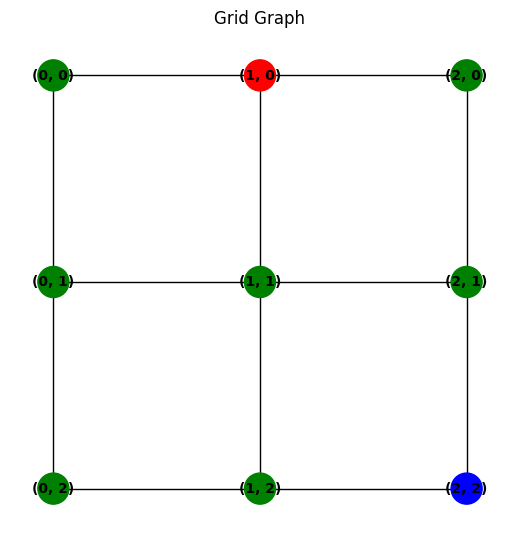

step 0 : -1.4142135623730951
action : 0


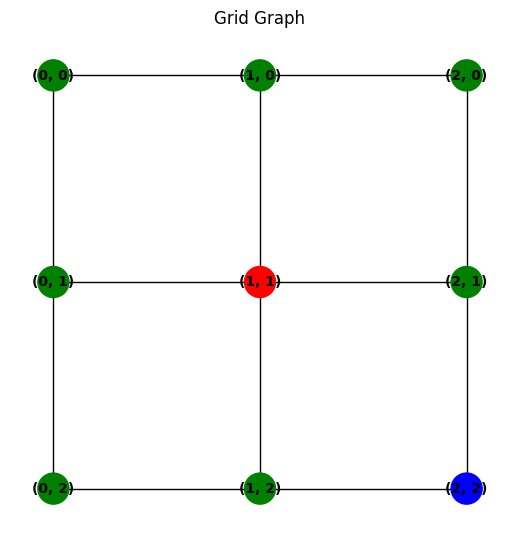

step 1 : -1.0
action : 1


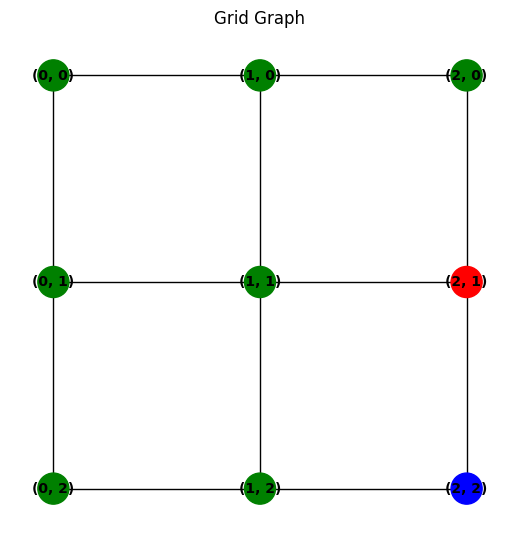

step 2 : 100
action : 0


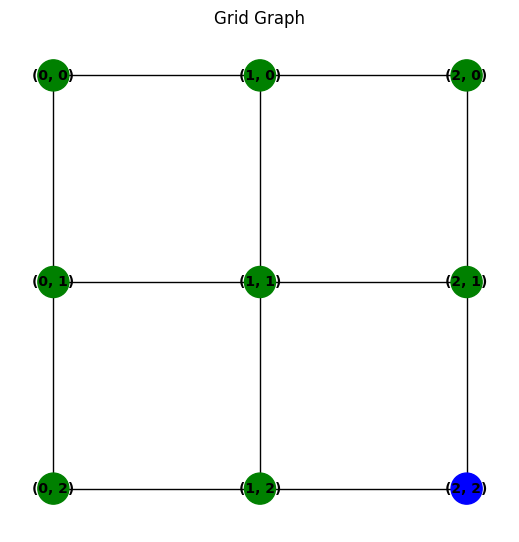

100

In [205]:
dqn.evaluate()

In [1]:
# save model
import torch
torch.save(dqn.q_network.state_dict(), "4x4.pt")

NameError: name 'dqn' is not defined

OrderedDict([('transformer_encoder.multi_head_attention.fc_Q.weight', tensor([[-0.7256]])), ('transformer_encoder.multi_head_attention.fc_Q.bias', tensor([0.1844])), ('transformer_encoder.multi_head_attention.fc_K.weight', tensor([[0.0095]])), ('transformer_encoder.multi_head_attention.fc_K.bias', tensor([-0.2365])), ('transformer_encoder.multi_head_attention.fc_V.weight', tensor([[-0.5711]])), ('transformer_encoder.multi_head_attention.fc_V.bias', tensor([0.2163])), ('transformer_encoder.multi_head_attention.uni_head.weight', tensor([[-0.0025]])), ('transformer_encoder.multi_head_attention.uni_head.bias', tensor([-0.0881])), ('transformer_encoder.fc.weight', tensor([[0.8666]])), ('transformer_encoder.fc.bias', tensor([-0.8549])), ('transformer_encoder.norm.weight', tensor([1.])), ('transformer_encoder.norm.bias', tensor([0.])), ('fc1.weight', tensor([[ 0.0652, -0.2724,  0.0871,  ...,  0.0385,  0.0461, -0.0745],
        [-0.0115, -0.5656, -0.0068,  ..., -0.0197, -0.2201, -0.3031],
    

In [203]:
print(dqn.q_network.transformer_encoder.multi_head_attention.fc_Q.weight)

Parameter containing:
tensor([[-0.7256]], requires_grad=True)
